# Бейзлайн

## Модель по подготовленным фичам

### Импортируем библиотеки

In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier as not_xgb
from sklearn.metrics import f1_score
%matplotlib inline
from matplotlib import pyplot as plt

### Подгружаем данные

In [3]:
df = pd.read_csv('train_data_prepared.csv', sep=';')
df_test = pd.read_csv('test_data_prepared.csv', sep=';')

### Описываем данные

Размеры выборок

In [4]:
print(df.shape)
print(df_test.shape)

(6285, 909)
(351, 908)


В тестовой выборке нет таргета

In [5]:
print(set(df.columns).difference(df_test.columns))

{'target'}


Количество разных типов фичей

In [6]:
df.dtypes.value_counts()

float64    900
int64        6
object       3
dtype: int64

Рейт первого класса

In [7]:
df.target.value_counts(normalize=True)

0    0.537947
1    0.462053
Name: target, dtype: float64

In [8]:
rate_period = df.groupby('period').target.value_counts(normalize=True)
rate_period.name = 'rp'
rate_period = rate_period.reset_index()
rate_period = rate_period[rate_period.target == 1]

Рейт первого класса по периодам

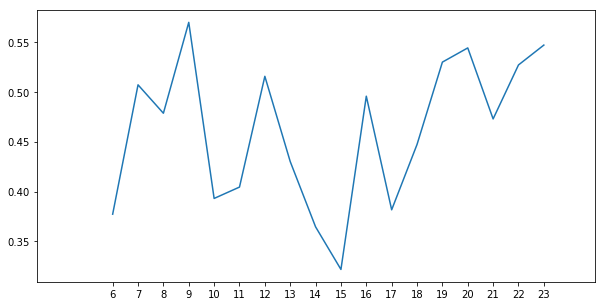

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(rate_period.period, rate_period.rp)
ax.set_xlim(left=3, right=25)
ax.set_xticks(rate_period.period);

Количество различных банкоматов

In [10]:
df.atm_id.nunique()

351

In [11]:
df.atm_id.value_counts().value_counts()

18    318
17     33
Name: atm_id, dtype: int64

у 33 банкоматов история на 1 короче

### Строим модель

#### Цель: предсказать по каждому банкомату наличие поломок в 24й период

Избавляемся от object фичей

In [12]:
print('{:30} {}'.format('column', 'nunique'))
for col in df.dtypes[df.dtypes == 'object'].index:
    print('{:30} {}'.format(col, df[col].nunique()))

column                         nunique
cash_in_out                    2
display_type                   2
scanner_code_reader            2


In [13]:
df = pd.get_dummies(df, drop_first=True, columns=df.dtypes[df.dtypes == 'object'].index)
df_test = pd.get_dummies(df_test, drop_first=True, columns=df_test.dtypes[df_test.dtypes == 'object'].index)

Оставлем 23й период на валидацию

In [14]:
df_train, df_valid = df[df.period < 23], df[df.period == 23]

In [15]:
model = not_xgb(random_state=42)
model.fit(df_train.drop(['target', 'period'], axis=1), df_train.target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

Выберем cutoff

In [16]:
df_valid.target.value_counts(normalize=True)

1    0.547009
0    0.452991
Name: target, dtype: float64

In [17]:
pd.Series(model.predict_proba(df_valid.drop(['target', 'period'], axis=1))[:, 1] > 0.404).astype(int).value_counts(normalize=True)

0    0.547009
1    0.452991
dtype: float64

0.404 было подобрано таким образом, чтобы на валидационной выборке рейт класса 1 совпадал

In [18]:
cutoff = 0.404
f1_score(df_valid.target, model.predict_proba(df_valid.drop(['target', 'period'], axis=1))[:, 1] > cutoff)

0.6609686609686609

In [33]:
baseline = pd.Series((model.predict_proba(df_test.drop(['period'], axis=1))[:, 1] > cutoff).astype(int))
baseline = baseline.to_frame().reset_index()
baseline.columns = ['ATM_ID', 'PREDICT']

In [35]:
baseline.to_csv('commit.csv', index=False)